In [1]:
import pylhe
import ROOT
import math
import os
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
import xlrd


Welcome to JupyROOT 6.20/04


In [2]:
m_axlist = [100,80,65,50,40,30]
x_seclist = [4584, 5583, 6640, 7858, 8969, 10220]

In [3]:
def file_np(file):
    event = [ file["Delphes;1"]["Electron"].array(),
              file["Delphes;1"]["Electron.PT"].array(),
              file["Delphes;1"]["Electron.Eta"].array(),
              file["Delphes;1"]["Electron.Phi"].array(),
              file["Delphes;1"]["Muon"].array(),                #4
              file["Delphes;1"]["Muon.PT"].array(),
              file["Delphes;1"]["Muon.Eta"].array(),
              file["Delphes;1"]["Muon.Phi"].array(),
              file["Delphes;1"]["Photon"].array(),              #8
              file["Delphes;1"]["Photon.PT"].array(),
              file["Delphes;1"]["Photon.Eta"].array(),
              file["Delphes;1"]["Photon.Phi"].array(),
              file["Delphes;1"]["MissingET"].array(),           #12
              file["Delphes;1"]["MissingET.fUniqueID"].array(),   
              file["Delphes;1"]["MissingET.fBits"].array(),
              file["Delphes;1"]["MissingET.MET"].array(),
              file["Delphes;1"]["MissingET.Eta"].array(),
              file["Delphes;1"]["MissingET.Phi"].array(),
              file["Delphes;1"]["Jet"].array(),                 #18
              file["Delphes;1"]["Jet.EhadOverEem"].array(),     
              file["Delphes;1"]["Jet.Mass"].array(),
              file["Delphes;1"]["Event.Number"].array(),
              file["Delphes;1"]["Jet.Tau[5]"].array(),
              file["Delphes;1"]["Event.CrossSection"].array()
              ]
    
    event = np.expand_dims(event, axis=-1)    ### reshape data
    event = event.transpose((1,0,2))
    event = np.squeeze(event,axis=(2,))
    return event 
    

In [4]:
m_axlist = [100,80,65,50,40,30]


bg_file = uproot.open("/data/event/final/bg_ppaalvll/Events/run_01/tag_1_delphes_events.root")
bg_events = file_np(bg_file)

sg_events = {}

for m_ax in m_axlist:
    sg_file_path = f"/data/event/final/sg_{m_ax}ppwax/Events/run_01/tag_1_delphes_events.root"
    sg_file = uproot.open(sg_file_path)
    sg_events[m_ax] = file_np(sg_file)
    
    
    

In [5]:
me = 0.000511
mu = 0.10566


max_shift = m_ax*0.1
max_u = m_ax + max_shift
max_d = m_ax - max_shift
################################################
def prlen(events):
    print(len(events))

################################################  sel
def num_sl(event,lab,num):
    where1 = np.where(event[:,lab]==num)
    return event[where1]

def l_sl(event):
    where1 = np.where(event[:,0]+event[:,4]==1)
    return event[where1]
       
################################################  maa caculate
def m_aa(events, m, pt1):
    where1=[]   
    for i in range(len(events)):
        p = [0,0,0,0] 
        for j in range(events[i][8]):
            pt = events[i][9][j]   
            eta = events[i][10][j]  
            phi = events[i][11][j]    
            p[1] = p[1] + pt*np.cos(phi)    ### px
            p[2] = p[2] + pt*np.sin(phi)    ### py
            p[3] = p[3] + pt*np.sinh(eta)   ### pz
            p[0] = p[0] + np.sqrt( (pt*np.cos(phi))**2 + (pt*np.sin(phi))**2 + (pt*np.sinh(eta))**2 )     
        maa = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
        m.append(maa)
        pTaa = np.sqrt(p[1]**2 + p[2]**2)
        pt1.append(pTaa)
        if max_d<maa<max_u:
            where1.append(i)
    return events[where1]
################################################        
def pt_sl(events):
    where1=[]
    for i in range(len(events)):
        p = [0,0,0,0]    
        for j in range(events[i][8]):
            pt = events[i][9][j]    
            eta = events[i][10][j]    
            phi = events[i][11][j]   
            p[1] = p[1] + pt*np.cos(phi)    ### px
            p[2] = p[2] + pt*np.sin(phi)    ### py
        pTaa = np.sqrt(p[1]**2 + p[2]**2)    
        if pTaa>50:
              where1.append(i)
    return events[where1]
################################################
def mvl_sl(events,m):
    for i in range(len(events)):
        p = [0,0,0,0]
        if events[i][0]==1:
            pt1  = events[i][1][0]    
            eta1 = events[i][2][0]    
            phi1 = events[i][3][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(me**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 + (pt1*np.sinh(eta1))**2)+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2 + (pt2*np.sinh(eta2))**2)
            mlv = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
        elif events[i][4]==1 :
            pt1  = events[i][5][0]    
            eta1 = events[i][6][0]    
            phi1 = events[i][7][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(mu**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 + (pt1*np.sinh(eta1))**2)+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2 + (pt2*np.sinh(eta2))**2)
            mlv = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 - p[3]**2)
        m.append(mlv)
################################################## must 1l events
def MTvl_sl(events,m,pt):
    where1=[]
    for i in range(len(events)):
        p = [0,0,0,0]
        if events[i][0]==1:
            pt1  = events[i][1][0]    
            eta1 = events[i][2][0]    
            phi1 = events[i][3][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(me**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 )+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2)
            mlv  = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 )
            ptlv = np.sqrt(p[1]**2 + p[2]**2 )
        elif events[i][4]==1 :
            pt1  = events[i][5][0]    
            eta1 = events[i][6][0]    
            phi1 = events[i][7][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(mu**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 )+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2 )
            mlv = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 )
            ptlv = np.sqrt(p[1]**2 + p[2]**2 )
        
        m.append(mlv)
        pt.append(ptlv)
        if mlv > 58:
            where1.append(i)
    return(events[where1])
##################################################   
def PTvl_sl(events,m,pt):
    where1=[]
    for i in range(len(events)):
        p = [0,0,0,0]
        if events[i][0]==1:
            pt1  = events[i][1][0]    
            eta1 = events[i][2][0]    
            phi1 = events[i][3][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(me**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 )+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2)
            mlv  = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 )
            ptlv = np.sqrt(p[1]**2 + p[2]**2 )
        elif events[i][4]==1 :
            pt1  = events[i][5][0]    
            eta1 = events[i][6][0]    
            phi1 = events[i][7][0]
            pt2  = events[i][15][0]    
            eta2 = events[i][16][0]    
            phi2 = events[i][17][0]
            
            p[1] = pt1*np.cos(phi1) + pt2*np.cos(phi2)    ### px
            p[2] = pt1*np.sin(phi1) + pt2*np.sin(phi2)    ### py
            p[3] = pt1*np.sinh(eta1)+ pt2*np.sinh(eta2)   ### pz
            p[0] = np.sqrt(mu**2 + (pt1*np.cos(phi1))**2 + (pt1*np.sin(phi1))**2 )+np.sqrt((pt2*np.cos(phi2))**2 + (pt2*np.sin(phi2))**2 )
            mlv = np.sqrt(p[0]**2 - p[1]**2 - p[2]**2 )
            ptlv = np.sqrt(p[1]**2 + p[2]**2 )
        m.append(mlv)
        pt.append(ptlv)
        if ptlv > 50:
            where1.append(i)
    return(events[where1])
#######################################################################################
def phi_v(events,phi_list):
    for i in range(len(events)):
        if events[i][0]==1:
            for j in range(len(events[i][3])):
                phi = (events[i][2][j])
                phi_list.append(phi)
        elif events[i][4]==1:
            for j in range(len(events[i][7])):
                phi = events[i][6][j]
                phi_list.append(phi)  
                
def miss_v(events,phi_list):
    for i in range(len(events)):
        for j in range(len(events[i][16])):
            phi = (events[i][17][j])
            phi_list.append(phi)
########################################################################################
def significance(s,b):   ### t = (sigma b)^2
    t = (b*0.05)**2
    g = 2*((s+b)*np.log((s+b)*(b+t)/(b**2+(s+b)*t))-((b**2)/t)*np.log(1+(t*s/(b*(b+t)))))
    return np.sqrt(g)

########################################################################################
def z_2(f, left, right, epsilon=1e-12):
    if left >= right:
        return None

    while abs(right - left) > epsilon:
        mid = (left + right) / 2
        f_mid = f(mid,b)-2
        if f_mid == 0:
            return mid
        elif f_mid < 0:
            left = mid
        elif f_mid > 0:
            right = mid

    return (left + right) / 2

In [6]:
def base_sl(sg_events):
    sgsl_2a = num_sl(sg_events,8,2)
    sgsl_2a_1l = l_sl(sgsl_2a)
    
    return len(sgsl_2a_1l)



bgsl_2a = num_sl(bg_events,8,2)
bgsl_2a_1l = l_sl(bgsl_2a)

base_num = []
s_base_num = []



for i, m_ax in enumerate(m_axlist):
    num = base_sl(sg_events[m_ax])
    base_num.append(num)
    
    s = x_seclist[i] * (num / len(sg_events[m_ax])) * 300
    s_base_num.append(s)

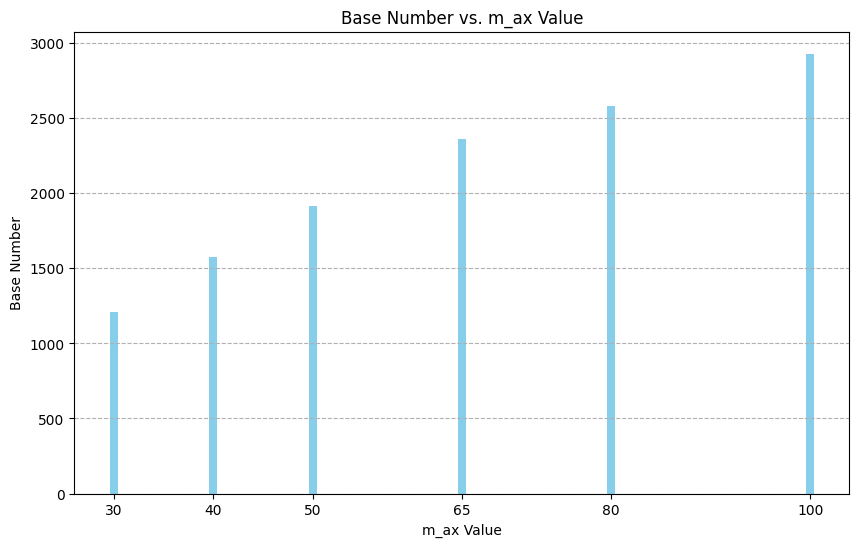

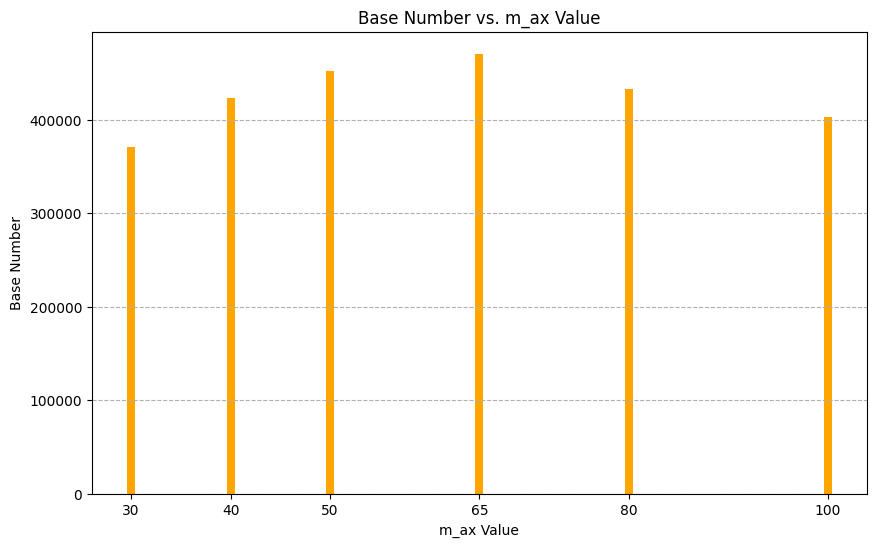

In [7]:
plt.figure(figsize=(10, 6))
plt.bar(m_axlist, base_num, color='skyblue')
plt.xlabel('m_ax Value')
plt.ylabel('Base Number')
plt.title('Base Number vs. m_ax Value')
plt.xticks(m_axlist)
plt.grid(axis='y', linestyle='--')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(m_axlist, s_base_num, color='orange')
plt.xlabel('m_ax Value')
plt.ylabel('Base Number')
plt.title('Base Number vs. m_ax Value')
plt.xticks(m_axlist)
plt.grid(axis='y', linestyle='--')


plt.show()

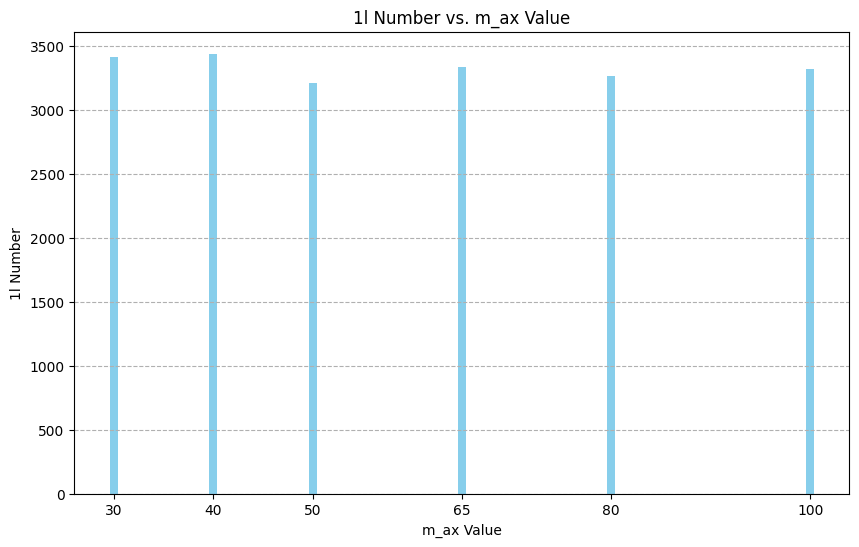

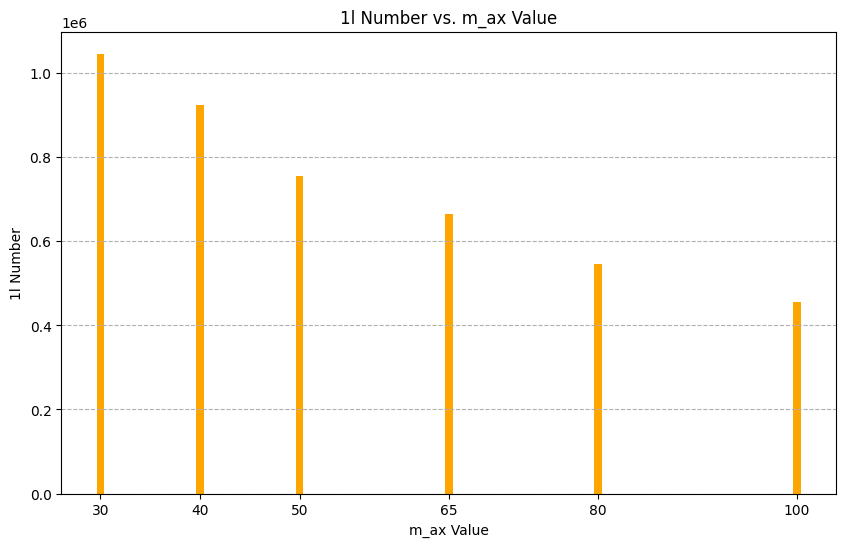

In [50]:


base_num = []
s_base_num = []



for i, m_ax in enumerate(m_axlist):
    num = len(num_sl(sg_events[m_ax],18,1))
    base_num.append(num)
    
    s = x_seclist[i] * (num / len(sg_events[m_ax])) * 300
    s_base_num.append(s)
    
plt.figure(figsize=(10, 6))
plt.bar(m_axlist, base_num, color='skyblue')
plt.xlabel('m_ax Value')
plt.ylabel('1l Number')
plt.title('1l Number vs. m_ax Value')
plt.xticks(m_axlist)
plt.grid(axis='y', linestyle='--')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(m_axlist, s_base_num, color='orange')
plt.xlabel('m_ax Value')
plt.ylabel('1l Number')
plt.title('1l Number vs. m_ax Value')
plt.xticks(m_axlist)
plt.grid(axis='y', linestyle='--')


plt.show()

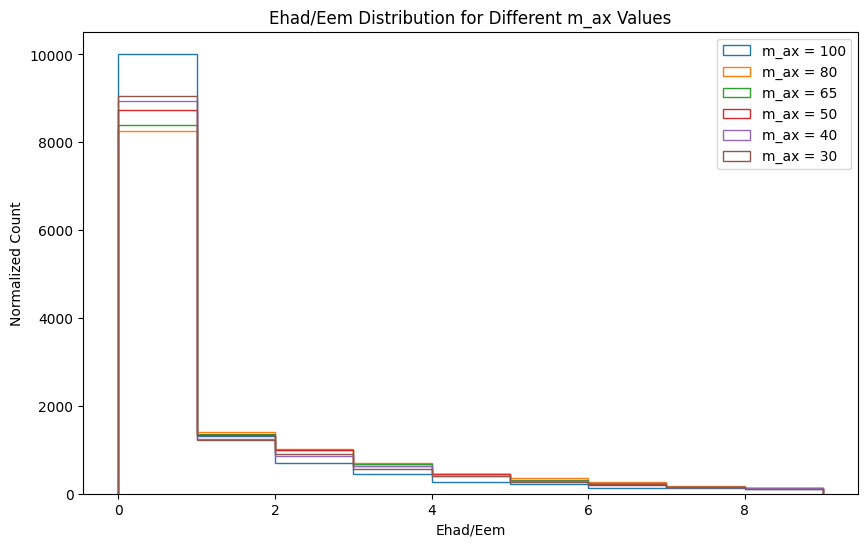

In [70]:



base_num_dict = {}

for m_ax in m_axlist:
    base_num_dict[m_ax] = []
    events = sg_events[m_ax]

    for event in events:
        if len(event[19]) > 0:
            base_num_dict[m_ax].extend(event[19])


            

plt.figure(figsize=(10, 6)) 

bins = np.arange(0,10,1)

for m_ax, values in base_num_dict.items():
    plt.hist(values, bins=bins, label=f'm_ax = {m_ax}', histtype='step')

plt.xlabel('Ehad/Eem')  
plt.ylabel('Normalized Count') 
plt.title('Ehad/Eem Distribution for Different m_ax Values') 
plt.legend() 
plt.show()  

In [14]:
print(sg_events[30][:,1])

[array([14.280035], dtype=float32) array([62.03881], dtype=float32)
 array([], dtype=float32) ... array([], dtype=float32)
 array([], dtype=float32)
 array([25.294353, 19.703344, 16.044327], dtype=float32)]


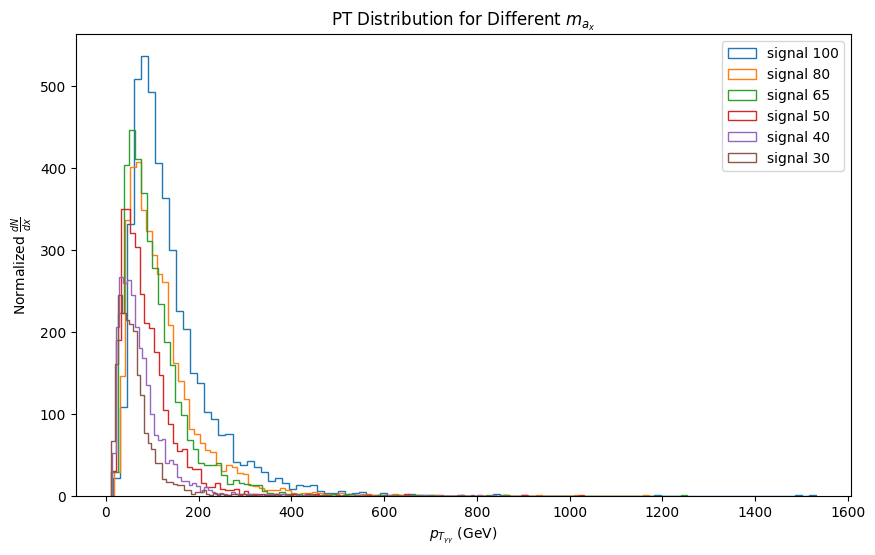

In [38]:
plt.figure(figsize=(10, 6))  # 创建一个图形实例

for ma_x in m_axlist:
    num = num_sl(sg_events[ma_x], 8, 2)
    elements_list = [arr[0] for arr in num[:, 9]]
    

    plt.hist(elements_list, label=f"signal {ma_x}", histtype='step',bins=100)


plt.xlabel(r"$p_{T_{\gamma\gamma}}$ (GeV)")
plt.ylabel(r"Normalized $\frac{dN}{dx}$")
plt.title('PT Distribution for Different $m_{a_x}$')
plt.legend()  # 显示图例

plt.show()  # 在循环结束后显示图表

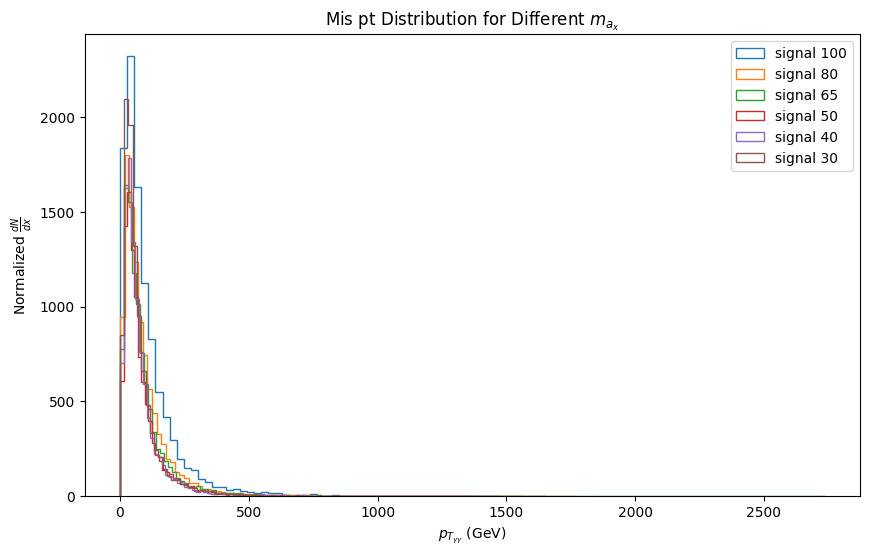

In [72]:
plt.figure(figsize=(10, 6))  # 创建一个图形实例

for ma_x in m_axlist:
    elements_list = [arr[0] for arr in sg_events[ma_x][:, 15]]
    

    plt.hist(elements_list, label=f"signal {ma_x}", histtype='step',bins=100)


plt.xlabel(r"$p_{T_{\gamma\gamma}}$ (GeV)")
plt.ylabel(r"Normalized $\frac{dN}{dx}$")
plt.title('Mis pt Distribution for Different $m_{a_x}$')
plt.legend()  # 显示图例

plt.show()  # 在循环结束后显示图表